# Proyecto 1: Analítica de textos

## Miembros
- Estudainte 3: Mariana Pineda Miranda - 202123330
- Estudiante 2: Isaac David Bermúdez- 202014146
- Estudiante 1: Joseph Linares Gutierrez - 202111887

In [108]:
import re

import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV


pd.set_option('display.max_columns', None)   # todas las columnas
pd.set_option('display.width', None) 

## Perfilamiento y análisis de datos

### Carga de datos

In [109]:
dataTrain = pd.read_csv("data/train.csv")
dataTest = pd.read_csv("data/test.csv")

In [110]:
dataTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB


### Conteo de elementos

In [111]:
dataTrain['textos'].value_counts()

textos
"Aprendizaje" y "educación" se consideran sinónimos de escolarización formal. Las organizaciones auxiliares, como las editoriales de educación, las juntas examinadoras y las organizaciones de formación de docentes, se consideran extensiones de los acuerdos establecidos por los gobiernos. Este marco de comprensión se ha vuelto cada vez más inadecuado.                                                                                                                                                                                                                                                                                                                                                                                                                       1
El arrendamiento de grandes porciones de estas tierras consuetudinarias a propietarios privados afecta a la seguridad alimentaria y a todas las actividades de subsistencia de quienes antes dependían de estos recursos naturales. Los 

In [112]:
dataTrain['labels'].value_counts()

labels
4    1025
3     894
1     505
Name: count, dtype: int64

In [113]:
dataTrain['textos'].str.len().describe()

count    2424.000000
mean      683.223185
std       223.563695
min       303.000000
25%       513.000000
50%       647.000000
75%       809.250000
max      1492.000000
Name: textos, dtype: float64

### Nulidad de elementos

In [114]:
dataTrain.isnull().sum()

textos    0
labels    0
dtype: int64

## Tratamiento de Datos

### Establecer StopWords (scapy)

In [115]:
from spacy.lang.es.stop_words import STOP_WORDS

# Listas de palabras a agregar (adicionar a stopwords)
palabras_conectoras = ['y', 'e', 'además', 'también', 'incluso', 'más', 'pero', 'aunque', 'sino']

# Listas de palabras a conservar (eliminar de stopwords)
palabras_de_Negacion = ['no', 'ni', 'nunca', 'jamás', 'tampoco',
                        'sin', 'ningún', 'ninguna', 'ninguno', 
                        'ningunos', 'ningunas', 'nada', 'nadie',
                        'haber', 'faltar', 'carecer','escasez', 
                        'ausencia', 'inaccesible', 'inaccesibilidad']

palabras_de_poder = ['puedo', 'puede', 'pueden', 'podemos', 'podría', 'podrían']


STOPWORDS = set(STOP_WORDS)
STOPWORDS = {w.lower() for w in STOPWORDS}

STOPWORDS.update(palabras_conectoras)
STOPWORDS.difference_update(palabras_de_Negacion)
STOPWORDS.difference_update(palabras_de_poder)

print(len(STOP_WORDS))
print(STOP_WORDS)

521
{'buena', 'parece', 'él', 'ella', 'doce', 'eramos', 'señaló', 'usa', 'cuanto', 'nuestras', 'que', 'hacer', 'podriamos', 'suyo', 'cuánto', 'pueden', 'haces', 'fue', 'he', 'fuera', 'sus', 'cualquier', 'diferente', 'nuevo', 'alguna', 'el', 'o', 'propia', 'segundo', 'podemos', 'al', 'tener', 'saben', 'fuimos', 'bajo', 'mis', 'buenos', 'enfrente', 'habían', 'otros', 'esas', 'mias', 'vuestros', 'breve', 'nosotras', 'entre', 'verdadero', 'diferentes', 'ahi', 'esto', 'manifestó', 'menudo', 'otra', 'así', 'próximos', 'mío', 'hicieron', 'indicó', 'tienen', 'aquéllos', 'habia', 'haciendo', 'tuya', 'estan', 'nadie', 'considera', 'detrás', 'consideró', 'medio', 'fueron', 'sabes', 'paìs', 'estuvo', 'ultimo', 'despues', 'podrias', 'llevar', 'dicen', 'hecho', 'grandes', 'tengo', 'cuatro', 'tanto', 'qeu', 'desde', 'tendrán', 'donde', 'proximo', 'ser', 'podrá', 'somos', 'adelante', 'cierta', 'nuestro', 'estoy', 'durante', 'luego', 'nueva', 'tiene', 'tarde', 'lo', 'vuestras', 'once', 'vamos', 'dado',

### Cargar el modelo NLP (scapy)

In [116]:
import spacy

nlp = spacy.load('es_core_news_md', disable=['ner','textcat']) # no se utiliza NER ni textcat


### Lematización + Normalización de palabras - Minusculas y acentos 

In [117]:
def lematizarTexto(textos):
    return [" ".join(t.lemma_.lower() for t in doc if t.is_alpha)  #Claramente lo hizo Chat
            for doc in nlp.pipe(textos, batch_size=128)]

dataTrain['lemas'] = lematizarTexto(dataTrain['textos'].astype(str).tolist())

In [118]:
dataTrain['lemas']

0       aprendizaje y educación él considerar sinónimo...
1       para el niño más pequeño bebé y niño pequeño e...
2       además el formación de especialista en medicin...
3       en el país de el ocde él tender a pasar de el ...
4       este grupo él centrar en el persona que padece...
                              ...                        
2419    el tutoría de carrera estar diseñado para apoy...
2420    fuente ministerio de educación el tasas intern...
2421    y desde el pnud haber ser pionero en el puesta...
2422    sin embargo este falla del mercado implicar qu...
2423    aunque existir programa para convertir él espe...
Name: lemas, Length: 2424, dtype: object

### Vectorización con TF-IDF

In [119]:
textoVectorizado = TfidfVectorizer(
    stop_words=sorted(STOPWORDS),
    ngram_range=(1,2),
    min_df=2, 
    max_df=0.9,
    lowercase=True,
    strip_accents=None 
)

X = textoVectorizado.fit_transform(dataTrain["lemas"].fillna("").astype(str))
y = dataTrain["labels"].to_numpy()

## Algoritmos

### Logistic Regression - Joseph Linares

In [120]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)

print("F1-score promedio:", f1_score(y_val, y_pred, average='weighted'))
print(classification_report(y_val, y_pred))

F1-score promedio: 0.9542597353431148
              precision    recall  f1-score   support

           1       0.97      0.88      0.92       101
           3       0.94      0.96      0.95       179
           4       0.96      0.99      0.97       205

    accuracy                           0.95       485
   macro avg       0.96      0.94      0.95       485
weighted avg       0.95      0.95      0.95       485



### Naive Bayes - Mariana Pineda Miranda


In [121]:
#Divido mis datos entre test y train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

#Algoritmo de Naive Bayes
naive_b = MultinomialNB()
naive_b.fit(X_train, y_train)

y_pred = naive_b.predict(X_test)
y_pred_train = naive_b.predict(X_train)

print("TEST DATA")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n")

print("TRAIN DATA")
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("\nClassification Report:\n", classification_report(y_train, y_pred_train))
print("\nConfusion Matrix:\n", confusion_matrix(y_train, y_pred_train))




TEST DATA
Accuracy: 0.9443298969072165

Classification Report:
               precision    recall  f1-score   support

           1       0.99      0.79      0.88       112
           3       0.93      0.98      0.96       168
           4       0.94      1.00      0.96       205

    accuracy                           0.94       485
   macro avg       0.95      0.92      0.93       485
weighted avg       0.95      0.94      0.94       485


Confusion Matrix:
 [[ 89  11  12]
 [  1 165   2]
 [  0   1 204]]


TRAIN DATA
Accuracy: 0.9783393501805054

Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.91      0.95       393
           3       0.98      0.99      0.99       726
           4       0.97      1.00      0.98       820

    accuracy                           0.98      1939
   macro avg       0.98      0.97      0.97      1939
weighted avg       0.98      0.98      0.98      1939


Confusion Matrix:
 [[356  13  24]
 [  0 

### Linear SVM - Mariana Pineda

In [122]:
base = LinearSVC()
clf = CalibratedClassifierCV(estimator=base, method="sigmoid", cv=5)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_train = clf.predict(X_train)
y_proba = clf.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
f1m = f1_score(y_test, y_pred, average="macro")

print("TEST DATA")
print(f"Accuracy: {acc:.4f}")
print(f"F1-macro: {f1m:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n")

print("TRAIN DATA")
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("\nClassification Report:\n", classification_report(y_train, y_pred_train))
print("\nConfusion Matrix:\n", confusion_matrix(y_train, y_pred_train))

TEST DATA
Accuracy: 0.9732
F1-macro: 0.9711

Classification Report:
               precision    recall  f1-score   support

           1       0.96      0.96      0.96       112
           3       0.97      0.98      0.97       168
           4       0.98      0.98      0.98       205

    accuracy                           0.97       485
   macro avg       0.97      0.97      0.97       485
weighted avg       0.97      0.97      0.97       485


Confusion Matrix:
 [[107   2   3]
 [  3 164   1]
 [  1   3 201]]


TRAIN DATA
Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       393
           3       1.00      1.00      1.00       726
           4       1.00      1.00      1.00       820

    accuracy                           1.00      1939
   macro avg       1.00      1.00      1.00      1939
weighted avg       1.00      1.00      1.00      1939


Confusion Matrix:
 [[393   0   0]
 [  0 726   0]
 

========================================================================
# Esta toca pa cuando probemos los datos de Test
========================================================================

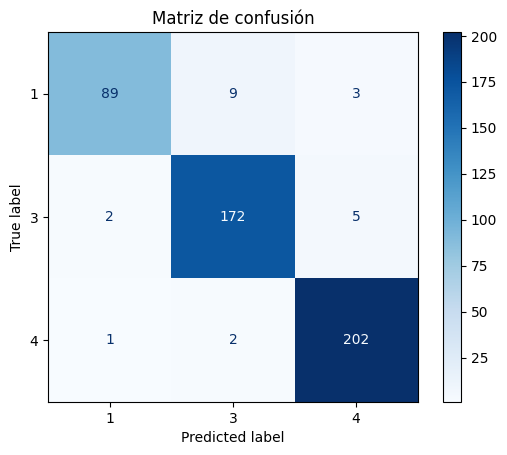

In [105]:
cm = confusion_matrix(y_val, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues')
plt.title("Matriz de confusión")
plt.show()